# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/2322/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs) (deleted from notebook) <br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [62]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [63]:
# Fill in the median and maximum number of user_article interactios below

# 50% of individuals interact with ____ number of articles or fewer.
median_val = np.median(np.array(df.groupby('email')['article_id'].count().sort_values(ascending=False)))

# The maximum number of user-article interactions by any 1 user is ______.
max_views_by_user = df['email'].value_counts().max() 

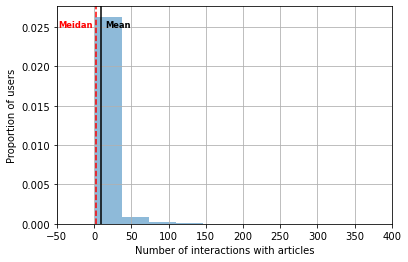

In [64]:
df['email'].value_counts().hist(density=True, alpha=0.5);
plt.xlabel('Number of interactions with articles');
plt.ylabel('Proportion of users');
plt.axvline(df['email'].value_counts().mean(), color='black');
plt.axvline(df['email'].value_counts().median(), color='red', linestyle='--');
plt.xlim(-50, 400);
plt.annotate('Mean', (15, 0.025), color='black', weight='bold',fontsize='small');
plt.annotate('Meidan', (-48, 0.025), color='red', weight='bold', fontsize='small');

Data highly skewed since most articles are interacted with few times but some many times (as many as 362 times).

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [65]:
# Remove duplicate articles in df_content
df_content_clean = df_content.drop_duplicates(['article_id'],keep='first')

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [66]:
# The number of unique articles that have at least one interaction
unique_articles = df[['email','article_id']].dropna().sort_values(by='email')['article_id'].nunique() 

# The number of unique articles on the IBM platform
total_articles = df_content_clean['article_id'].count()

# The number of unique users
unique_users = df['email'].nunique() 

# The number of user_article_interactions
user_article_interactions = df['article_id'].count()

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [67]:
# The most viewed article in the dataset as a string with one value following the decimal 
most_viewed_article_id = str(df['article_id'].value_counts().index[0])

# The most viewed article in the dataset was viewed how many times?
max_views = df['article_id'].value_counts().max()

In [68]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [69]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


#### Converting article_id to string

### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [70]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    Description: 
    Returns top article titles 
    
    '''
    top_articles = list(df['title'].value_counts().sort_values(ascending=False).index)[0:n]
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    Description: 
    Returns top article ids     
    
    '''
    top_articles = list(df['article_id'].value_counts().sort_values(ascending=False).index)[0:n]
    
    return top_articles 

In [71]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


In [72]:
# Convert article_id entries to strings
df['article_id'] = df['article_id'].apply(str)

### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [73]:
def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''

    user_item = pd.get_dummies(df['article_id']).groupby(df['user_id']).apply(max)
    return user_item

user_item = create_user_item_matrix(df)

In [74]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [75]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered list of most similar users to a given user
    
    '''    
    similarity_score = []
    
    # Get row of user-article interaction associated with user_id
    user_data = user_item.iloc[user_id-1]
    
    for user in user_item.index:
        # Calculate similarity (i.e. dot product) between user with user_id and each user in the user_item matrix
        
        # Append user_id and corresponding similarity score (as a tuple) to list of similarity scores
        similarity_score.append((user, user_data.dot(user_item.iloc[user-1])))    
        
    # Sort list by similarity score        
    similarity_score_sorted = sorted(similarity_score, key=lambda x: x[1], reverse=True)
    
    most_similar_users = []

    for a_tuple in similarity_score_sorted: 
        # For each tuple, extract the first element of the tuple (i.e. the user_id) and append to most_similar_user list
        most_similar_users.append(a_tuple[0])

    # Remove user_id corresponding to user from most similar_users list
    most_similar_users.remove(user_id)
          
    return most_similar_users 
        

In [76]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 49]
The 5 most similar users to user 3933 are: [1, 23, 3782, 203, 4459]
The 3 most similar users to user 46 are: [4201, 23, 3782]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [77]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
                    
    Description:
    Return article titles for a given list of article ids
    '''
    article_names = list(df[df['article_id'].isin(article_ids)]['title'].unique())
    
    return article_names 


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Return a list of the article_ids and article titles that have been seen by a user
    '''
    article_ids = list(df[df['user_id']==user_id]['article_id'])
    article_names = get_article_names(article_ids)
    
    
    return article_ids, article_names 


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    seen_ids, seen_names = get_user_articles(user_id)
    
    similar_users = find_similar_users(user_id)
    
    new_recs = []
    
    for similar_user in similar_users:
        if len(new_recs) < m:
            rec_ids, rec_names = get_user_articles(similar_user)
            new = list(np.setdiff1d(rec_ids, seen_ids))

            for i in new:
                if len(new_recs) < m:
                    new_recs.append(i)

    return new_recs 

In [78]:
# Check Results

# Return 10 recommendations for user 1
get_article_names(user_user_recs(1, 10)) 

['analyze energy consumption in buildings',
 'analyze accident reports on amazon emr spark',
 '520    using notebooks with pixiedust for fast, flexi...\nName: title, dtype: object',
 '1448    i ranked every intro to data science course on...\nName: title, dtype: object',
 'data tidying in data science experience',
 'airbnb data for analytics: vancouver listings',
 'recommender systems: approaches & algorithms',
 'airbnb data for analytics: mallorca reviews',
 'analyze facebook data using ibm watson and watson studio',
 'a tensorflow regression model to predict house values']

In [79]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [80]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
                    
    Description: 
    For a given user, with user_id = user_id, determine the similarity between user and each other user
    and for each user, determine the number of times that user has interacted with articles, count each 
    interaction including repeated interactions with articles. Create dataframe of similar user ids and
    corresponding similarity and interaction scores. Return the dataframe sorted by similarity score first
    and then number of interactions. 
    
    '''
    # Get user-article interactions for user_id = user_id
    user_data = user_item.iloc[user_id-1]
    
    # Get list of all user_ids
    user_ids = user_item.index
    
    sim_score = []
    num_interactions = []

    for user in user_ids:
        # Find similarity between user_id = user_id and user by finding the dot product
        sim_score.append(user_data.dot(user_item.iloc[user-1]))
        
        # Count the number of times user interacts with an article
        interact_count = df[df['user_id']==user].count()['article_id']
        num_interactions.append(interact_count)
    
    # Put similarity score and interaction count corresponding to each user in a datafame
    d = {'neighbor_id': user_ids, 'similarity': sim_score, 'interactions': num_interactions}
    neighbors_df = pd.DataFrame(data=d)
    
    # Remove row in dataframe corresponding to user = user)id 
    neighbors_df = neighbors_df[neighbors_df['neighbor_id']!=user_id]
    
    # Sort dataframe by similarity score first and then interaction count
    neighbors_df = neighbors_df.sort_values(by=['similarity','interactions'], ascending=False)
    
    return neighbors_df 


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    seen_ids, seen_articles = get_user_articles(user_id)
    
    ordered_neighbors = get_top_sorted_users(user_id)
    
    neighbors = np.array(ordered_neighbors['neighbor_id'])
    
    rec_ids = []

    for neighbor in neighbors:
        if len(rec_ids) < m:
            neighbor_ids, neighbor_articles = get_user_articles(neighbor)
            new_article_ids = np.setdiff1d(neighbor_ids, seen_ids)
            
            for article_id in new_article_ids: 
                if len(rec_ids) < m:
                    rec_ids.append(article_id)
            
    recs = rec_ids
    rec_names = get_article_names(rec_ids)
            
    return recs, rec_names

In [81]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['1024.0', '1085.0', '109.0', '1150.0', '1151.0', '1152.0', '1153.0', '1154.0', '1157.0', '1160.0']

The top 10 recommendations for user 20 are the following article names:
['airbnb data for analytics: washington d.c. listings', 'analyze accident reports on amazon emr spark', 'tensorflow quick tips', 'airbnb data for analytics: venice listings', 'airbnb data for analytics: venice calendar', 'airbnb data for analytics: venice reviews', 'using deep learning to reconstruct high-resolution audio', 'airbnb data for analytics: vienna listings', 'airbnb data for analytics: vienna calendar', 'airbnb data for analytics: chicago listings']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [82]:
### Tests with a dictionary of results

# Find the user that is most similar to user 1 
user1_most_sim = get_top_sorted_users(1).iloc[0]['neighbor_id'] 

# Find the 10th most similar user to user 131
user131_10th_sim = get_top_sorted_users(131).iloc[9]['neighbor_id'] 

In [83]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

#### Answer: 
- If we were given a new user, there would be no user-item interaction data for the user (i.e. cold start problem), so ranked based recommendations could be used to recommend articles to this user. This could be done using the 'get_top_articles' function (see Part II).
- A better way to make recommendations may be to use a knowledge based recommendation strategy. 
    - The user may be asked to select specific topics which they are interested in. A method which first filters the articles by topic and then by popularity (measured by number of interactions) could be implemented. 
    - To do this, articles would need to be tagged with the relevant topic.

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [84]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.

# Provide a list of the top 10 article ids you would give to 
new_user_recs = get_top_article_ids(10)

In [85]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [86]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [87]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [88]:
# Perform SVD on the User-Item Matrix 
u, s, vt = np.linalg.svd(user_item_matrix)
u.shape, s.shape, vt.shape

((5149, 5149), (714,), (714, 714))

#### Why does SVD work in this case?
- Since there are no missing values (since the matrix entry is a binary rather than a rating) the entire user_item matix can be used for SVD. 
- If there was missing data, FunkSVD may have been used.

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

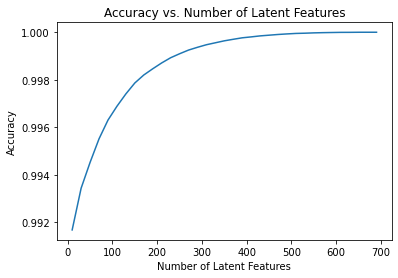

In [89]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # Restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # Take dot product to produce estimate of user_item matrix
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))

    # Compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # Total errors and keep track of error for each amount of latent feature by appending to sum_errs
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/(user_item_matrix.shape[0]*user_item_matrix.shape[1]))
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [90]:
# Split data into train and test datasets
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    Description: 
    Takes train and test dataframes and converts each to user_item matrix. 
    Return user_item_test and user_item_train matrices, list of users and list of articles in user_item_test matrix
    '''
    user_item_train = create_user_item_matrix(df_train)
    
    user_item_test = create_user_item_matrix(df_test)
    
    test_idx = user_item_test.index
    
    test_arts = user_item_test.columns 
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [91]:
# Replace the values in the dictionary below


print('Number of users in the test set that are not in the train set:', len(np.setdiff1d(test_idx, user_item_train.index)))
print('Number of users in the test set that are in the train set:', len(np.intersect1d(test_idx, user_item_train.index)))
print('Number of articles in the test set that are not in the train set:', len(np.setdiff1d(test_arts, user_item_train.columns)))
print('Number of articles in the test set that are in the train set:', len(np.intersect1d(test_arts, user_item_train.columns)))


a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many articles can we make predictions for in the test set?': b,
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?': d,
}

t.sol_4_test(sol_4_dict)

Number of users in the test set that are not in the train set: 662
Number of users in the test set that are in the train set: 20
Number of articles in the test set that are not in the train set: 0
Number of articles in the test set that are in the train set: 574
Awesome job!  That's right!  All of the test articles are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [92]:
# Perform SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train) 

In [93]:
# Identify the users in the user_item_test matrix that are also in the user_item_train matrix 
user_ids_intersect = np.intersect1d(test_idx,  user_item_train.index)
user_item_test_subset = user_item_test.loc[user_ids_intersect]

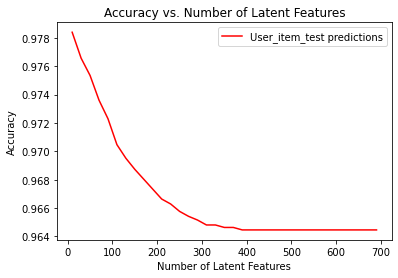

In [94]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # Restructure matrices with k latent features
    u_train_new = u_train[:, :k]
    s_train_new = np.diag(s_train[:k])
    vt_train_new = vt_train[:k, :]
    
    # Taken the subset of the u_train and vt_train matrices with users and articles present in the user_item_test matrix
    u_train_subset = u_train_new[user_item_train.index.isin(test_idx), :]
    vt_train_subset = vt_train_new[:, user_item_train.columns.isin(test_arts)]
    
    # Create user_item_estimate matrix using the subset of u_train and vt_train
    user_item_est = np.around(np.dot(np.dot(u_train_subset, s_train_new), vt_train_subset))
    
    # Determine the error between each user_item interaction in the test set and the user_item_estimate matrix
    diff_test = np.abs(np.subtract(user_item_test_subset, user_item_est))
    
    # Find the total error for each user
    error = np.sum(diff_test.sum())
    
    # Append the total error to the list of errors
    sum_errs.append(error)
    
# Visualise the accuracy as a function of number of latent features
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/(user_item_test_subset.shape[0]*user_item_test_subset.shape[1]), color = 'red');
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');
plt.legend(['User_item_test predictions']);

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

#### Discussion of results in part 5:
- High accuracy (96.4 - 97.8 %) expected since the same users and articles are in both datasets. 
- It is expected that as the number of latent features increases so too will the accuracy, however the opposite relationship was observed (see Accuracy vs. Number of Latent Features graph for user_item_test predictions above). 
- This may have occurred since the matrix decomposition was done on the entire train set which included 4487 users and 714 articles, whilst the subset of test data which predictions were made on was much smaller only 20 users and 514 articles. There were likely less (relevant) latent features in the user_item_test subset than the user_item_train set. 

#### Determine if recommendations you make with above recommendation systems are an imporvement to how users currently find article:
- Offline testing: Split existing data into train and test data, fit to train data, and evaluate using test data. Your data should be split such that older data is in your training set and newer data in your test set.
    - In practice, this would look like using for example user_user_recs_part2 (collaborative filtering) to make recommendations of articles to similar users. The recommendations would be evaluated by computing the error between the  recommendations made to whether or not users in the test set interacted with the articles.


- Online testing: Deploy recommendation strategy, measure change in metrics, do A/B test to evaluate if the change is sufficiently significant. 
    - Metric example: Change in average number of interactions per user. 
        - Null hypothesis: Change in average number of interactions per user <= 0 
        - Alternative hypothesis: Change in average number of interactions per user > 0
        - Alpha and beta both need to be set before running A/B test
        - Required length of test period needs to be calculated to determine if test is feasible
        - One potential con of measuring number of interactions per user as a proxy for quality of recommendatin system is that if 'bad' articles are recommended then a user may interact with many articles (more than prior to deployment of this recommendation system) before finding one that is useful. Therefore it may be incorrectly concluded that the recommendation system should be deployed.



- User groups: Get feedback from user groups on articles recommended to them.
    - Questions and ratings need to be determined. Granularity of answers needs to be determined.
    - User group needs to be representative of the population.